## Syntax Tree Generation

In [95]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 as cv
import pytesseract
from PIL import Image

## Initializing Images - Data structures

In [96]:
A = np.array(Image.open('test_images/new.jpg'))
A = cv.resize(A, dsize=(800, 600), interpolation=cv.INTER_CUBIC)

BLOCK_ID = 0

# list that holds block object information
block_list = []

class code_block:
    def __init__(self, b_id, text, x, y):
        self.b_id = b_id
        self.text = text
        self.coordinates = x, y
        self.next_block  = 0
        self.attached_block = 0
    def __str__(self):
        return 'block_id: {self.b_id} at {self.coordinates} -> next block {self.next_block} \n |-> {self.attached_block}'.format(self = self)


def new_block(text, x, y):
    global BLOCK_ID 
    BLOCK_ID += 1
    block_list.append(code_block(BLOCK_ID, text, x, y))


## Masking - Collecting Information

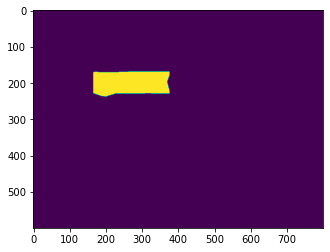

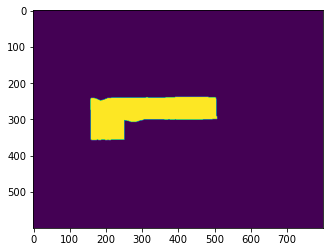

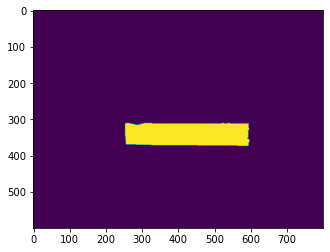

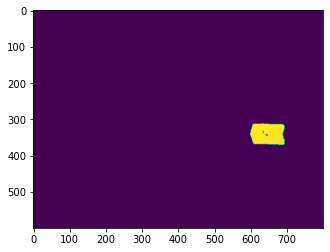

In [97]:
# mask generation based on Saturation #
# channel of hsv colorspace           #

# preparing image
hsv_A = cv.cvtColor(A, cv.COLOR_RGB2HSV)
copy_A = np.copy(A)
h,s,v = cv.split(hsv_A)
# threshold saturation chanel
ret3, th_saturation = cv.threshold(s, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
# dilating thresholded image to remove letters
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
th_saturation = cv.dilate(th_saturation, kernel, iterations = 3)
# using connected components (CC) method to label each block
num_labels, labels_im = cv.connectedComponents(th_saturation)

# Result: An image with each 'feature' (block) labeled with  #
# a (int) number                                             #

# for each block 
for num in range(1, num_labels):

    # Extracting mask from (CC) result
    label = labels_im == num
    block_mask = np.copy(th_saturation)
    block_mask[label == False] = 0
    block_mask[label == True] = 255

    # find coordinates (x, y) and hight - width of the block
    # (h, w)
    _, contours, _ = cv.findContours(block_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv.boundingRect(contours[0])

    # save block coordinates in an object
    new_block('', x, y)
    #cv.drawContours(copy_A, contours, -1, (0,255,0), 3)

    # Plot masking results
    plt.figure(figsize=(20,4))
    plt.imshow(block_mask)
    plt.show() 

## Generating Abstract Syntax Tree

In [101]:
temp_block_list = np.copy(block_list)


def find_block(b_id):
    for block in block_list:
        if block.b_id == b_id:
            return block


def find_closest_block(my_block):
    a_sum = my_block.coordinates[0]+my_block.coordinates[1]
    min_dif = a_sum
    min_id = 0
    for block in block_list:
        b_sum = block.coordinates[0]+block.coordinates[1]
        dif = np.abs(a_sum - b_sum)
        if (dif > 0) and (block.b_id != my_block.b_id) and block.coordinates[1] > my_block.coordinates[1]:
            #print('Distace from block {}, {}'.format(block.b_id, dif))
            if dif < min_dif:
                min_dif = dif
                min_id = block.b_id

    #print(min_dif, min_id)
    if min_id != 0:
        return min_id
    else:
        return None


def is_next(min_id, my_block):
    threshold = 20 # pixels
    block = find_block(min_id)
    dif = np.abs(block.coordinates[0] - my_block.coordinates[0])
    if dif < threshold:
        return True
    else:
        return False


def print_syntax_tree():
    for block in block_list:
        if block.next_block != 0:
            print('{}'.format(block.b_id))
            print(' | ')
        elif block.attached_block != 0:
            print('{} --> '.format(block.b_id), end =" ")
        elif block.attached_block == 0:
            print(block.b_id)


for block in block_list:
    min_id = find_closest_block(block)
    if min_id != None:
        if is_next(min_id, block):
            block.next_block = min_id
        else:
            block.attached_block = min_id

print_syntax_tree()


1
 | 
2 -->  3 -->  4
